In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
DIRECTORY = r"dataset"
CATEGORIES = ["with_mask", "without_mask"]

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

In [3]:
# Labeller üzerinde one-hot encoding işlemi uygulanıyor.
# Bu işlem sayesinde oluşturulan modellerin öğren performansı artıyor.
# Normalde label -> ["without_mask", "with_mask", .....] -> [0 1 0 1 1 0 ....] şeklinde oluyor.
# One-Hot Encoding işlemi ile [[1 0], [0 1], ....] şeklinde oluyor.
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Verileri numpy array formatına çeviriyor.
# Böylece yine modelin öğrenme performansı artıyor.
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Preprocess işleminden geçen veriler train ve test olarak ayrılıyor.
# test_size = 20%
# train_size = 80%
# stratify kullanarak train ve test verilerindeki aynı labela sahip verilerin eşit dağılmasını sağlar.
# random_state değerine integer bir değer verildiğinde veri setini karıştırarak train ve test verilerini ayırır.
(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

In [7]:
EPOCHS = 10
BS = 64

# Aldığı parametrelere göre orjinal görselden yararlanarak farklı görseller oluşturur. 
# Böylece öğrenme işlemi daha verimli gerçekleşir.
# rotation_range     = Derece aralığında döndürme işlemi uygulayarak farklı görseller oluşturmasını sağlar.
# zoom_range         = Görsele farklı ölçülerde zoom yapar.
# width_shift_range  = Görsele yatay eksende kaydırma işlemi uygular.
# height_shift_range = Görsele dikey eksende kaydırma işlemi uygular.
# shear_range        = Görseli saat yönünün tersinde kaydırma işlemi uygular
# horizontal_flip    = Görseli yatay olarak çevirir.
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest')

# CNN modeli oluşturuldu.
model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# EarlyStopping ile model ezberlemeye başlayınca 3 epoch içinde çalıştırmayı durduruyor.
es_callback = EarlyStopping(monitor='val_loss', patience=3)

# Model katmanlarının bilgisi ekrana çıktı olarak yazıldı.
model.summary()

# Oluşturulan CNN modeli eğitime başladı.
# auf.flow ile oluşturulan random görseller eğitim için modele gönderilir.
# epoch = Modelin kaç kere öğrenme işlemi uygulayacağını belirtir.
# batch_size = Her bir epoch da öğrenme verilerinden ne kadarını sinir ağına ekleneceğini belirtir.
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    verbose=1,
    validation_steps=len(testX) // BS,
    epochs=EPOCHS, 
    callbacks=[es_callback])

# Oluşturulan model daha sonra kameradan alınan görüntünün yorumlanmasında kullanılacağı için kayıt edildi.
model.save("mask_detector.model", save_format="h5")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 54, 54, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 93312)            

In [8]:
# Öğrenme işlemi tamamlandıktan sonra test için ayrılan veri seti üzerinden tahmin işlemi uygulanıyor. 
predict_y = model.predict(testX, batch_size=BS)

# Tahmin edilen verileri en yakın label türüne göre göstermek için uygulandı.
# Her görsel için [0,95 0,12] şeklinde bir array oluşur. Bunun anlamı aslında "Maske Yok" şeklinde olmaktadır.
# Bunun label olarak karşılığı 0'dır.
# Aşağıdaki kod bloğu ile 0 değeri elde edilir.
predict_y = np.argmax(predict_y, axis=1)

# Modelin elde ettiği sonuçları daha net yorumlayabilirmek için classification_report oluşturuldu.
print(classification_report(np.argmax(testY, axis=1), predict_y,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.93      0.97      0.95       383
without_mask       0.97      0.93      0.95       384

    accuracy                           0.95       767
   macro avg       0.95      0.95      0.95       767
weighted avg       0.95      0.95      0.95       767



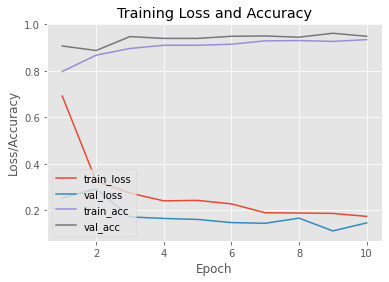

In [9]:
# Modelin sonuçları daha net incelenmesi için grafik oluşturuldu.
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(1, 11), history.history["loss"], label="train_loss")
plt.plot(np.arange(1, 11), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(1, 11), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(1, 11), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("mask_detector_plot.png")